# Part 3: EDA and Pre-Processing 

In this section pre-processing and EDA is implemented to prepare for modeling.

In [1]:
def high_corr(dataset, lim):
    
    highly_corr = []
    datacorr = dataset.corr()
    filtered = datacorr[((datacorr >= lim) | (datacorr <= -lim)) & (datacorr !=1.00)]
    filtered = filtered.unstack().sort_values(ascending=False).drop_duplicates()
    m = 0
    data_col =  dataset.columns
    data_len =  len(data_col)
    for data in dataset:
        m += 1 
        for i in range(data_len):
            n = i + m
            if n < data_len:
                col_name = data_col[n]
                cor = dataset[data].corr(dataset[col_name]) 
                if cor >= lim:
                    if data not in highly_corr:
                        highly_corr.append(data)
                    if col_name not in highly_corr:
                        highly_corr.append(col_name)
    print('Highly correlated columns')
    print(highly_corr)
    return filtered

# Data Cleaning & EDA

This section of the project is to import the data that were collected 
1. Import all necessary libraries 
2. Import the dataset
3. Overview of the data, feature engineering, and EDA.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder 
import matplotlib.pyplot as plt
import seaborn as sns

## Import Datasets

In [3]:
df = pd.read_csv('Datasets/booker_report.csv', low_memory=False, index_col=False)

In [4]:
df.shape

(800000, 33)

In [5]:
df.head()

,Unnamed: 0,ACCAP,AGE,GGDUM,BOOKER2,CAREER,AROFFAP,CIRCDIST,IMPACTOL,MPCTCHC,...,SENTIMP,OTCHPTS,WEAPON,XCRHISSR,LMIN,FY,USSCIDN,ENSPLT0,LOSS_2B,GDL
0,0,0,28,0,2,,0,80.0,,,...,1,5,0,3,10,2005.0,890751.0,8,,2L1.2
1,1,0,24,0,2,,0,80.0,,,...,1,3,0,2,168,2005.0,890752.0,72,,2A3.1
2,2,0,32,0,0,,0,33.0,,,...,1,3,0,2,12,2005.0,890755.0,15,,2D1.1
3,3,0,24,1,0,,0,33.0,,,...,1,10,1,5,228,2005.0,890756.0,270,,2D1.1
4,4,0,43,0,0,,0,93.0,,,...,1,9,0,4,57,2005.0,890757.0,60,,2L1.2


In [6]:
df.drop(columns='Unnamed: 0', inplace=True)

In [7]:
df.dtypes

ACCAP         object
AGE           object
GGDUM         object
BOOKER2       object
CAREER        object
AROFFAP       object
CIRCDIST     float64
IMPACTOL      object
MPCTCHC       object
MITDUM        object
MONCIRC      float64
ONSEX         object
NEWCIT        object
NEWCNVTN      object
EWEDUC        object
NEWRACE       object
OFFTYPE2      object
ERIOD         object
PRIMARY       object
QUARTER      float64
A             object
SAFEVALVE     object
SENTIMP       object
OTCHPTS       object
WEAPON        object
XCRHISSR      object
LMIN          object
FY           float64
USSCIDN      float64
ENSPLT0       object
LOSS_2B       object
GDL           object
dtype: object

In [8]:
# Fill white space no nan
def remove_wspaces(df):

    # get column
    for col in df.columns:
        # fill or replace the missing values by given val
        for i, data in enumerate(df[col]):
        
            # convert data type to str to verify it is nan
            if str(data).strip() == '':
                df.at[i, col] = np.nan

In [9]:
remove_wspaces(df)

In [10]:
df.isna().sum()

ACCAP          1639
AGE            1977
GGDUM           599
BOOKER2         984
CAREER       776873
AROFFAP        1640
CIRCDIST          0
IMPACTOL     798337
MPCTCHC      798337
MITDUM          585
MONCIRC           0
ONSEX          1258
NEWCIT         2739
NEWCNVTN        703
EWEDUC        26923
NEWRACE        5990
OFFTYPE2        129
ERIOD         26697
PRIMARY      474882
QUARTER           0
A               984
SAFEVALVE    415808
SENTIMP         940
OTCHPTS        1865
WEAPON            7
XCRHISSR         58
LMIN             69
FY                0
USSCIDN           0
ENSPLT0        2390
LOSS_2B      734975
GDL             580
dtype: int64

# Feature Engineering

### Handling Missing Values
- Drop columns with more than 75% missing values
- The missing values of AGE is imputed using median value.
- Impute the discrete values of the column type which nan values belong to Missing, Indeterminable, or Inapplicable with next sample space or take as another category. 

In [11]:
for col in df.columns:
    col_len = df.shape[0]
    # drop column if missing values > 75%
    if df[col].isna().sum()/col_len > 0.75:
        df.drop(columns=col, inplace=True)

In [12]:
# GDL: The Chapter Two Guideline applied in a case. For some offenses, several guidelines were combined in this variable.
# 2BNew = Fraud Offenses 2D1.1 = Drug Trafficking Offenses (includes 2D1.2) 2G2.1 = Child Pornography Production Offenses 2G2.2 = Child Pornography Possession 
# Offenses (includes 2G2.4) 2L1.1 = Alien Smuggling Offenses 2L1.2 = Illegal Entry Offenses 2K2.1 = Firearms Offenses 2_#.# = Chapter 2 Guideline Applied of 
# All Other Offenses · = Missing, Indeterminable, or Inapplicable 
# As this is our target, the missing values imputed with 'Other' category

df['GDL'] = df['GDL'].fillna('Other')

In [13]:
# Convert the categorical values of the target to numeric
# List of categorical values of the target 

cat_val = list(df['GDL'].unique())
target = {cat_val[i]: i for i in range(0, len(cat_val))}
df['GDL'].replace(target, inplace=True)
df['GDL'] = df['GDL'].astype(int)

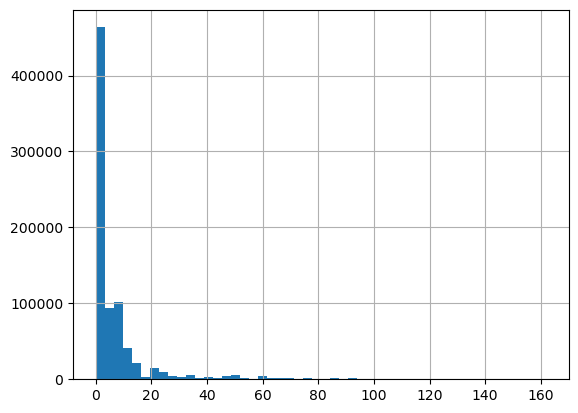

In [14]:
# Plotting histogram of the target (GDL guidelines)
df.GDL.hist(bins=50);

In [15]:
df['FY'].unique()

array([2005., 2006., 2007., 2008., 2009., 2010., 2011., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004.])

In [16]:
# Convert the year column to datetime
df['FY'] = pd.to_datetime(df['FY'], format = '%Y').dt.year
df['FY'].head(2)

0    2005
1    2005
Name: FY, dtype: int64

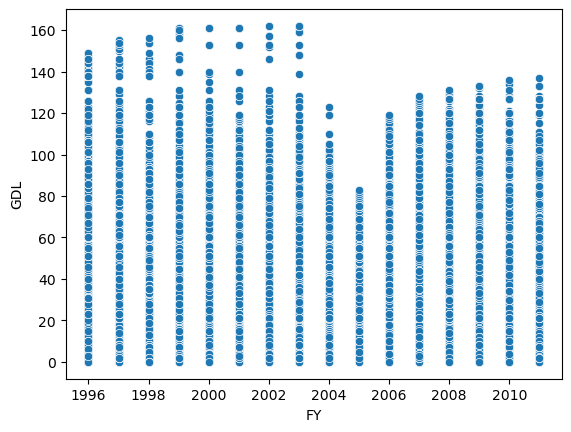

In [17]:
# GDL vs every year
sns.scatterplot(data = df, x = 'FY', y = 'GDL');

In [18]:
df['AGE'].dtypes

dtype('O')

In [19]:
# Identifies the age of the defendant at the time of sentencing. It is generated based on the date of birth provided either in the PSR or at case submission
# Range: 16 thru 98 · = Missing/Indeterminable
#Imputed Age column with median value
df['AGE'] = df['AGE'].fillna(df['AGE'].median())
df['AGE'] = df['AGE'].astype(int)

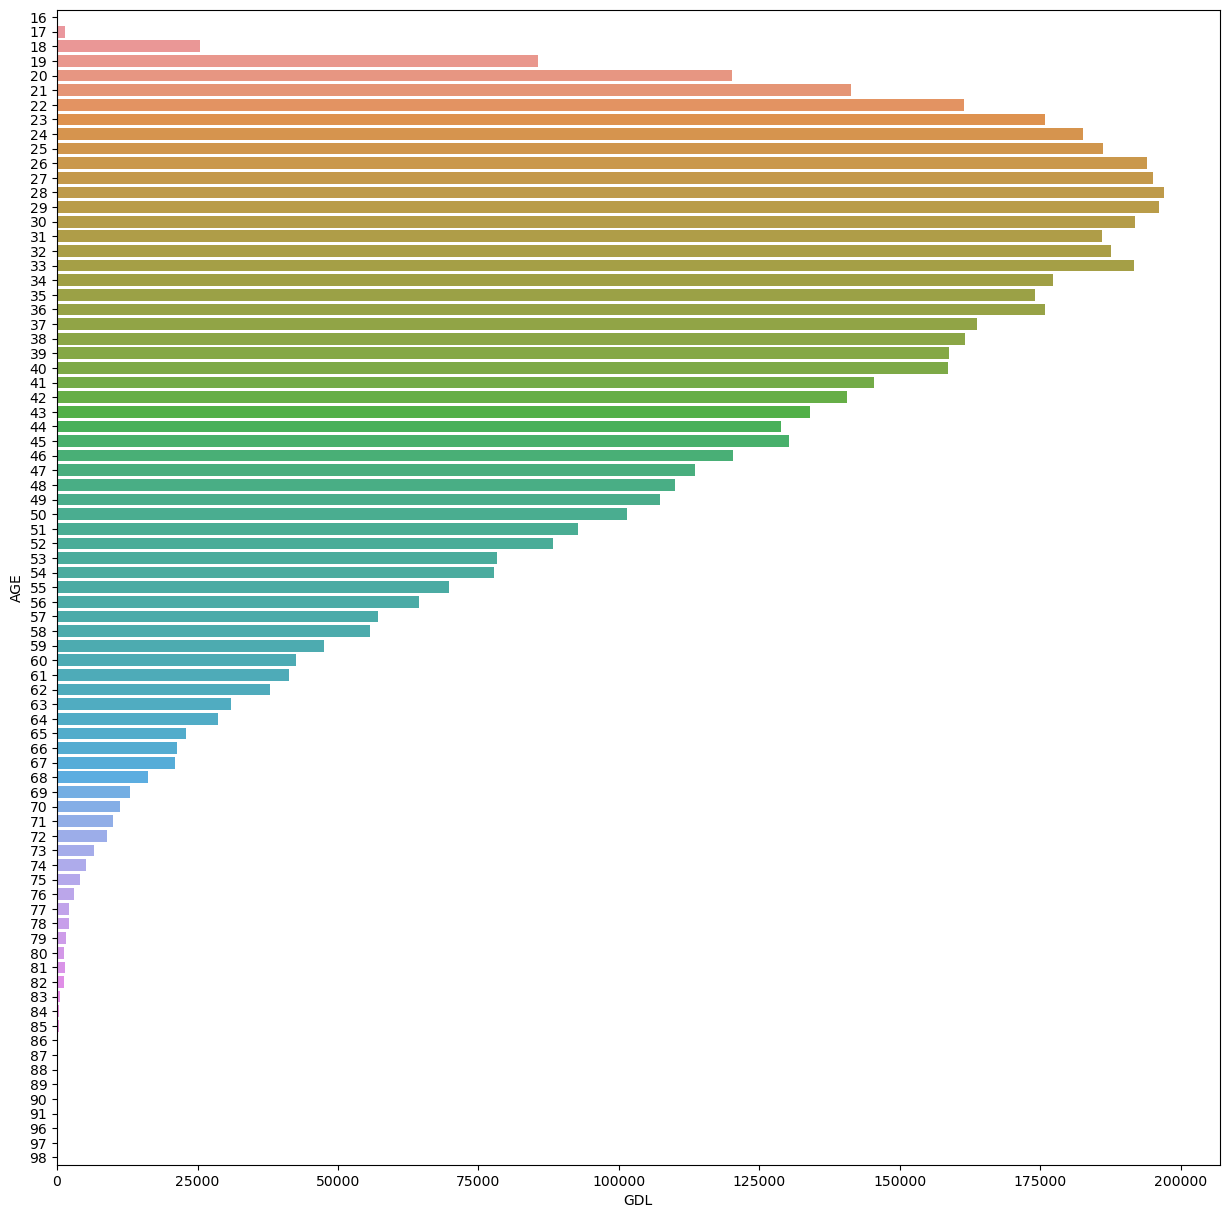

In [20]:
plt.figure(figsize = (15,15))
age_df = df[['AGE','GDL']].groupby('AGE')['GDL'].sum()
age_df = age_df.sort_values(ascending=False).reset_index()
sns.barplot(y='AGE', x='GDL', data=age_df.reset_index(),orient='h');

In [21]:
# ACCAP, Indicator of whether Armed Career Criminal status was applied under §4B1.4. 
# Values are 0, 1,  Missing, Indeterminable, or Inapplicable. Impute the Missing, Indeterminable, or Inapplicable 
# Imputed ACCAP column with median value as the number of missing values very small compared to the dataset given.
df['ACCAP'] = df['ACCAP'].fillna(df['ACCAP'].median())
df['ACCAP'] = df['ACCAP'].astype(int)

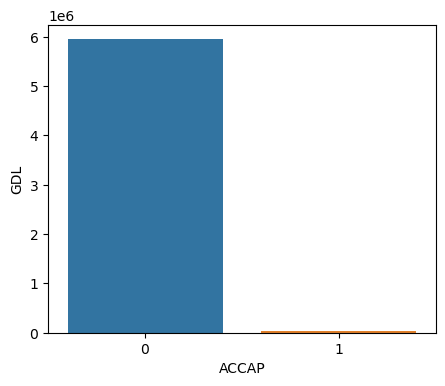

In [23]:
# This feature could be remove as it shows imbalanced.
plt.figure(figsize = (5,4))
accap_df = df[['ACCAP','GDL']].groupby('ACCAP')['GDL'].sum()
accap_df = accap_df.sort_values(ascending=False).reset_index()
sns.barplot(x='ACCAP', y='GDL', data=accap_df.reset_index());

In [24]:
# AGGDUM, Identifies the age of the defendant at the time of sentencing. It is generated based on the date of birth provided 
# Values areRange: 16 thru 98 · = Missing/Indeterminable. Impute the Missing/Indeterminable with 99
df['GGDUM'] = df['GGDUM'].fillna(99)
df['GGDUM'] = df['GGDUM'].astype(int)

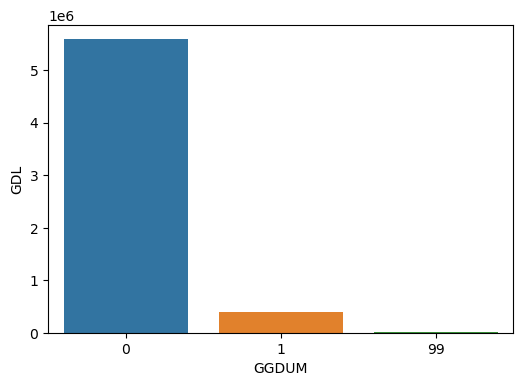

In [26]:
# This is another imbalanced data
plt.figure(figsize = (6,4))
ggdum_df = df[['GGDUM','GDL']].groupby('GGDUM')['GDL'].sum()
ggdum_df = ggdum_df.sort_values(ascending=False).reset_index()
sns.barplot(x='GGDUM', y='GDL', data=ggdum_df.reset_index());

In [27]:
# Offender’s sentence position relative to the guideline range based on relationship between the sentence and 
# guideline range and the reason(s)
# Values are 0 = Within Range, 1 = Above Departure, 2 = Government Sponsored, 3 = Below Range, · = Missing, Indeter
# Imputed the Missing values of 'BOOKER2' column with median value as the number of missing values very small compared to the dataset given.
df['BOOKER2'] =df['BOOKER2'].fillna(df['BOOKER2'].median())
df['BOOKER2'] =df['BOOKER2'].astype(int)

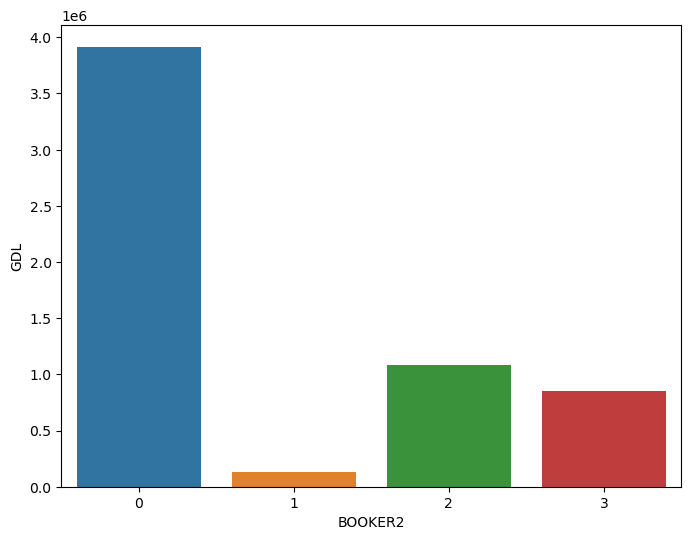

In [28]:
plt.figure(figsize = (8,6))
booker_df = df[['BOOKER2','GDL']].groupby('BOOKER2')['GDL'].sum()
booker_df = booker_df.sort_values(ascending=False).reset_index()
sns.barplot(x='BOOKER2', y='GDL', data=booker_df.reset_index());

In [29]:
# Indicator to whether Career Offender status was applied under §4B1.1.
# Values are 0 = Not Applied, 1 = Applied, · = Missing or Indeterminable. 
# Imputed the missing values with median value as the number of missing values very small compared to the dataset given.
df['AROFFAP'] = df['AROFFAP'].fillna(df['AROFFAP'].median())
df['AROFFAP'] = df['AROFFAP'].astype(int)

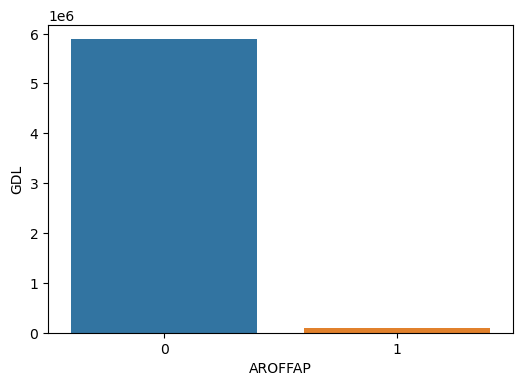

In [30]:
# This is another imbalanced data.
plt.figure(figsize = (6,4))
aro_df = df[['AROFFAP','GDL']].groupby('AROFFAP')['GDL'].sum()
aro_df = aro_df.sort_values(ascending=False).reset_index()
sns.barplot(x='AROFFAP', y='GDL', data=aro_df);

In [31]:
# MITDUM: Dummy variable for mitigating role application. Only valid values were included as having a mitigating role adjustment
# Values are  0 = No Adjustment Applied, 1 = Valid Value (negative 1-4), Applied, 
# · = Missing, Indeterminable, invalid value applied, or Inapplicable. 
# Imputed the missing values with median value as the number of missing values very small compared to the dataset given.
df['MITDUM'] = df['MITDUM'].fillna(df['MITDUM'].median())
df['MITDUM'] = df['MITDUM'].astype(int)

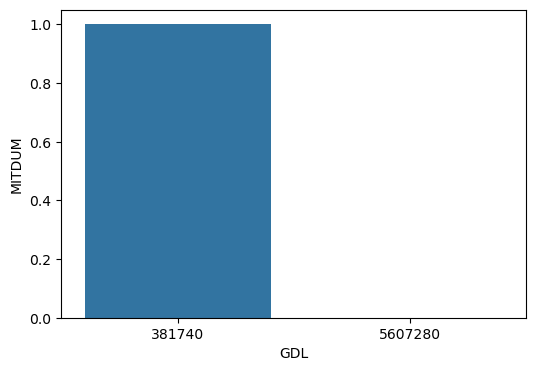

In [32]:
# This is imbalanced data
plt.figure(figsize = (6,4))
mit_df = df[['MITDUM','GDL']].groupby('MITDUM')['GDL'].sum()
mit_df = mit_df.sort_values(ascending=False).reset_index()
sns.barplot(y='MITDUM', x='GDL', data= mit_df.reset_index());

In [33]:
# MONSEX: Indicates the offender's gender
# Values 0 = Male, 1 = Female, · = Missing, Indeterminable, or Inapplicable. 
# Imputed the missing values with median value as the number of missing values very small compared to the dataset given.
df['ONSEX'] = df['ONSEX'].fillna(df['ONSEX'].median())
df['ONSEX'] = df['ONSEX'].astype(int)

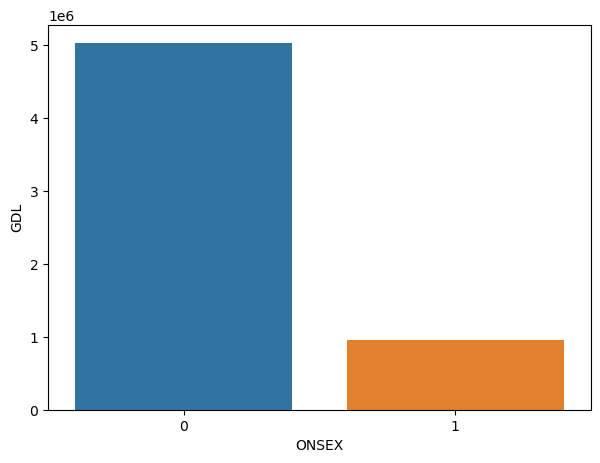

In [34]:
plt.figure(figsize = (7,5))
sex_df = df[['ONSEX','GDL']].groupby('ONSEX')['GDL'].sum()
sex_df = sex_df.sort_values(ascending=False).reset_index()
sns.barplot(x='ONSEX', y='GDL', data=sex_df.reset_index());

In [35]:
# NEWCIT: Citizenship of the defendant
# 0 = U.S. 1 = Non-U.S. (Includes Legal and Illegal Aliens) · = Missing, Indeterminable, or Inapplicable. 
# Imputed the missing values with median value as the number of missing values very small compared to the dataset given.
df['NEWCIT'] = df['NEWCIT'].fillna(df['NEWCIT'].median())
df['NEWCIT'] = df['NEWCIT'].astype(int)

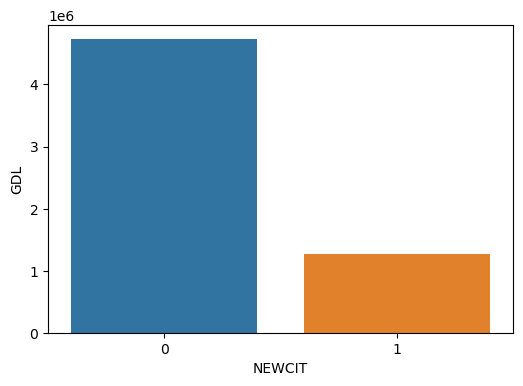

In [37]:
plt.figure(figsize = (6,4))
newc_df = df[['NEWCIT','GDL']].groupby('NEWCIT')['GDL'].sum()
newc_df = newc_df.sort_values(ascending=False).reset_index()
sns.barplot(x='NEWCIT', y='GDL', data=newc_df.reset_index());

In [38]:
# NEWCNVTN: Indicates whether the case was settled by plea agreement or trial.
# Values are 0 = Plea 1 = Trial, · =Missing, Indeterminable, or Inapplicable. 
# Imputed with median as the number shows very low
df['NEWCNVTN'] = df['NEWCNVTN'].fillna(df['NEWCNVTN'].median())
df['NEWCNVTN'] = df['NEWCNVTN'].astype(int)

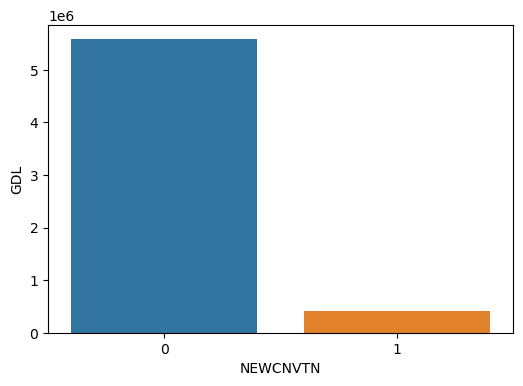

In [40]:
plt.figure(figsize = (6,4))
newcn_df = df[['NEWCNVTN','GDL']].groupby('NEWCNVTN')['GDL'].sum()
newcn_df = newcn_df.sort_values(ascending=False).reset_index()
sns.barplot(x='NEWCNVTN', y='GDL', data=newcn_df.reset_index());

In [41]:
# Highest level of education for offender
# Values are 1 = Less Than H.S. Graduate, 3 = H.S. Graduate, 5 = Some College, 6 = College Graduate, · = Missing, Indeterminable, or Inapplicable
# Imputed the missing values with another category or 7 as the values are very large
df['EWEDUC'] = df['EWEDUC'].fillna(7)
df['EWEDUC'] = df['EWEDUC'].astype(int)

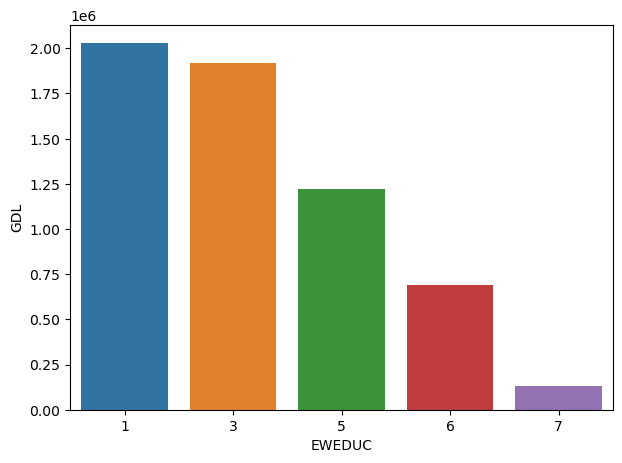

In [42]:
plt.figure(figsize = (7,5))
ewed_df = df[['EWEDUC','GDL']].groupby('EWEDUC')['GDL'].sum()
ewed_df = ewed_df.sort_values(ascending=False).reset_index()
sns.barplot(x='EWEDUC', y='GDL', data=ewed_df.reset_index());

In [43]:
# NEWRACE: Race of defendant.
# 1 = White, 2 = Black, 3 = Hispanic 6 = Other · = Missing, Indeterminable, or Inapplicable
# Imputed the missing value with median as the missing values are very low compare to the dataset
df['NEWRACE'] = df['NEWRACE'].fillna(df['NEWRACE'].median())
df['NEWRACE'] = df['NEWRACE'].astype(int)

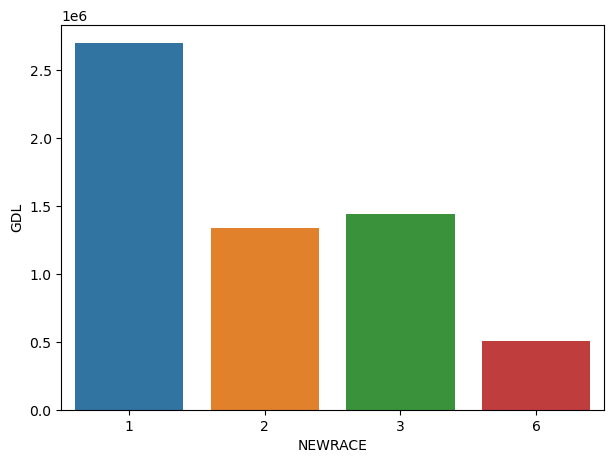

In [44]:
plt.figure(figsize = (7,5))
newr_df = df[['NEWRACE','GDL']].groupby('NEWRACE')['GDL'].sum()
newr_df = newr_df.sort_values(ascending=False).reset_index()
sns.barplot(x='NEWRACE', y='GDL', data=newr_df.reset_index());

In [45]:
# Primary offense type for the case, generated from the count of conviction with the highest statutory maximum (in 
# case of a tie, the count with the highest statutory minimum is used)
# Values are different type of offences type given number from 0 - 44. Imputed values using backfill as the value is very low (129)
df['OFFTYPE2'] = df['OFFTYPE2'].fillna(method = 'bfill') 
df['OFFTYPE2'] = df['OFFTYPE2'].astype(int)

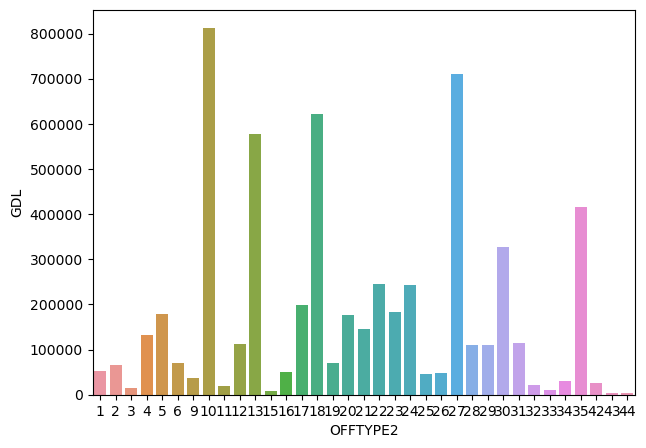

In [46]:
plt.figure(figsize = (7,5))
offt_df = df[['OFFTYPE2','GDL']].groupby('OFFTYPE2')['GDL'].sum()
offt_df = offt_df.sort_values(ascending=False).reset_index()
sns.barplot(x='OFFTYPE2', y='GDL', data=offt_df.reset_index());

In [47]:
# Time Period in which the case was sentenced. This field is generated based on the sentencing date.
# Values are Range: 1-4 1 = Koon Period (June 13, 1996 through April 30, 2003) 2 = PROTECT Act Period (May 1, 2003 through June 24, 2004) 
# 3 = Booker Period (January 12, 2005 through December 10, 2007) 4 = Gall Period (December 11, 2007 through September 30, 2011) . = Missing
# Imputed the missing values as another category and assigned 5 as the number very large and the description of the missing values
# are the sentencing date falls outside one of the specified time frames. 
df['ERIOD'] = df['ERIOD'].fillna(5) 
df['ERIOD'] = df['ERIOD'].astype(int)


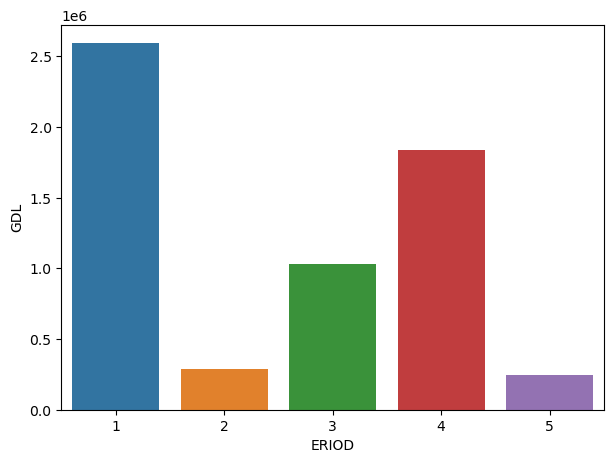

In [48]:
plt.figure(figsize = (7,5))
eriod_df = df[['ERIOD','GDL']].groupby('ERIOD')['GDL'].sum()
eriod_df = eriod_df.sort_values(ascending=False).reset_index()
sns.barplot(x='ERIOD', y='GDL', data=eriod_df.reset_index());

In [49]:
# Primary drug type involved in the offense standardized across all fiscal years. 
# Values are  1 = Cocaine 2 = Crack 3 = Heroin 4 = Marijuana 6 = Methamphetamine 77 = Other · = Missing, Indeterminable, or Inapplicable
# Imputed the missing values as another category and assigned 5 as the number very large 78

df['PRIMARY'] = df['PRIMARY'].fillna(78)
df['PRIMARY'] = df['PRIMARY'].astype(int)

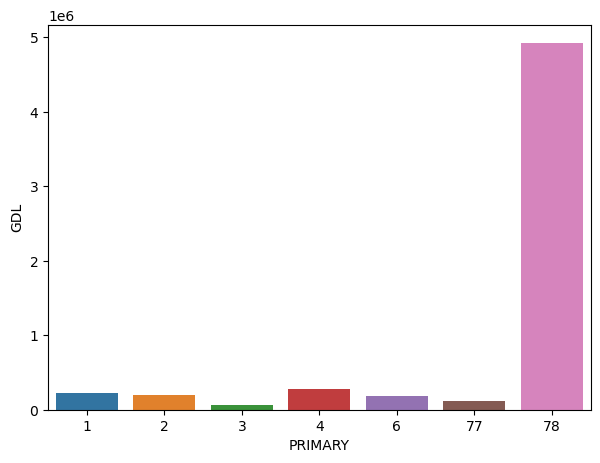

In [50]:
plt.figure(figsize = (7,5))
primary_df = df[['PRIMARY','GDL']].groupby('PRIMARY')['GDL'].sum()
primary_df = primary_df.sort_values(ascending=False).reset_index()
sns.barplot(x='PRIMARY', y='GDL', data=primary_df.reset_index());

In [51]:
# This variable is an expanded version of BOOKER2, with the different government sponsored categories broken out.
# Values 0 = Within Range 1 = Above Range 2 = 5K1.1/Substantial Assistance 3 = Early Disposition/5K3.1 4 = Government Sponsored - 
# Below Range 5 = Non-Govt Sponsored Below Range · = Missing, Indeterminable, or Inapplicable
# Imputed missing values using backfill as the number is very low
df['A'] = df['A'].fillna(method='bfill')
df['A'] = df['A'].astype(int)

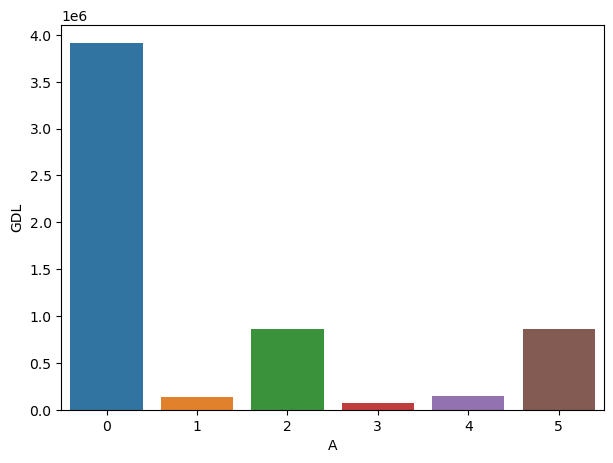

In [52]:
plt.figure(figsize = (7,5))
a_df = df[['A','GDL']].groupby('A')['GDL'].sum()
a_df = a_df.sort_values(ascending=False).reset_index()
sns.barplot(x='A', y='GDL', data=a_df.reset_index());

In [53]:
# Indicator of whether or not the “Safety Valve” provision (§5C1.2 or 2D1.1) was applied. Note that this provision is only applicable to drug cases.
# 0 = Safety Valve Not Applied 1 = Safety Valve Applied . = Missing, Indeterminable, or Inapplicable. 
# Values 0 = Within Range 1 = Above Range 2 = 5K1.1/Substantial Assistance 3 = Early Disposition/5K3.1 4 = Government Sponsored - 
# Below Range 5 = Non-Govt Sponsored Below Range · = Missing, Indeterminable, or Inapplicable
# Imputed missing values with another category and assigned 2 as the number is too large (> 50%).

df['SAFEVALVE'] = df['SAFEVALVE'].fillna(2)
df['SAFEVALVE'] = df['SAFEVALVE'].astype(int)

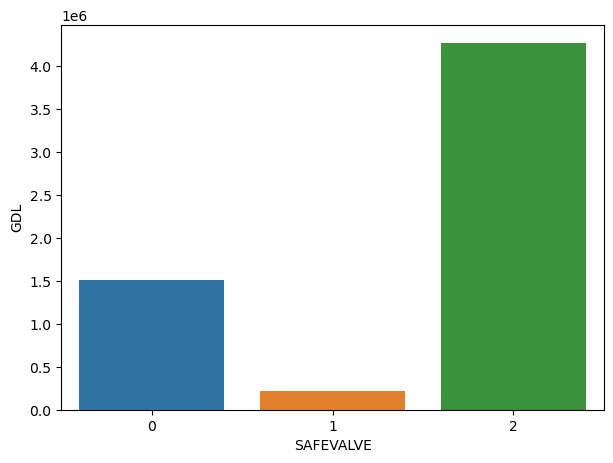

In [54]:
plt.figure(figsize = (7,5))
safe_df = df[['SAFEVALVE','GDL']].groupby('SAFEVALVE')['GDL'].sum()
safe_df = safe_df.sort_values(ascending=False).reset_index()
sns.barplot(x='SAFEVALVE', y='GDL', data=safe_df.reset_index());

In [55]:
# Indicates what type of sentence was given (prison, probation, probation plus alternatives, or prison/split sentence)
# 0 = No Prison/Probation (Fine Only) 1 = Prison Only (No Alternatives) 2 = Prison + Confinement Conditions (Alternatives, Including Zone C Split Sentences)
# 3 = Probation + Confinement Conditions (Alternatives) 4 = Probation Only · = Missing, Indeterminable, or Inapplicable
# Imputed missing values using backfill as the number is very low
df['SENTIMP'] = df['SENTIMP'].fillna(method = 'bfill')
df['SENTIMP'] = df['SENTIMP'].astype(int)

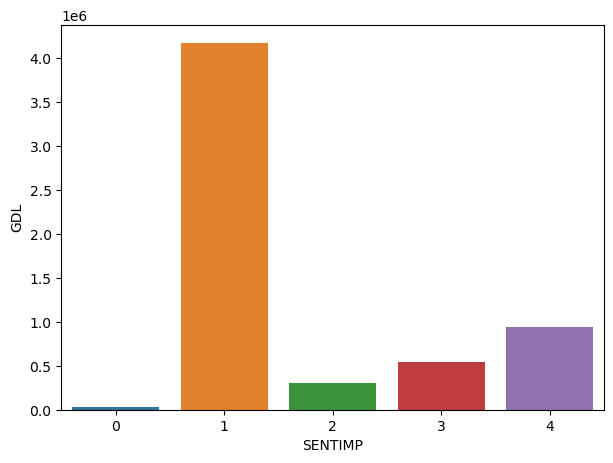

In [56]:
plt.figure(figsize = (7,5))
sent_df = df[['SENTIMP','GDL']].groupby('SENTIMP')['GDL'].sum()
sent_df = sent_df.sort_values(ascending=False).reset_index()
sns.barplot(x='SENTIMP', y='GDL', data=sent_df.reset_index());

In [57]:
# The total number of criminal history points applied.
# Values are Range: 0 thru 99 0 = None · = Missing, Indeterminable, or Inapplicable
# Imputed missing values using backfill as the number is very low
df['OTCHPTS'] = df['OTCHPTS'].fillna(method = 'bfill')
df['OTCHPTS'] = df['OTCHPTS'].astype(int)

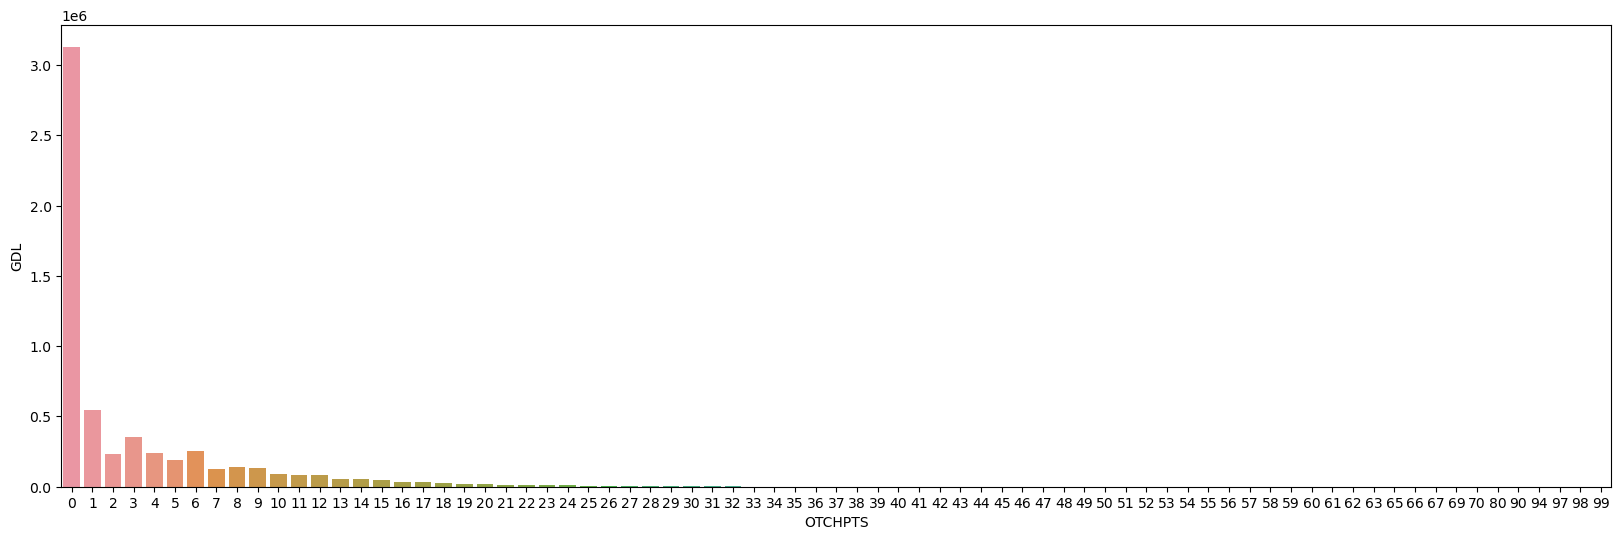

In [58]:
plt.figure(figsize = (20,6))
otc_df = df[['OTCHPTS','GDL']].groupby('OTCHPTS')['GDL'].sum()
otc_df = otc_df.sort_values(ascending=False).reset_index()
sns.barplot(x='OTCHPTS', y='GDL', data=otc_df.reset_index());

In [59]:
# Defendant's final criminal history category (I-VI), as determined by the court
# Range: 1 thru 6 · = Missing, Indeterminable, or Inapplicable
# Imputed missing values using backfill as the number is very low
df['XCRHISSR'] = df['XCRHISSR'].fillna(method = 'bfill')
df['XCRHISSR'] = df['XCRHISSR'].astype(int)

In [60]:
# Indicates if there is an SOC weapon enhancement or an 18§924(c) conviction.
# 0 = No SOC Weapon Enhancement Nor 18§924(c) Charge Present 1 = SOC Weapon Enhancement or 18§924(c) Charge Present · = Missing, Indeterminable, or Inapplicable
# Imputed the missing value with median as the missing values are very low

df['WEAPON'] = df['WEAPON'].fillna(method = 'bfill')
df['WEAPON'] = df['WEAPON'].astype(int)

In [61]:
# ENSPLT0: The trumped total prison sentence, in months (sentence of 470 months or more, including life, are reported as 470 months)
# Range: 0 thru 470 0 = Probation · = Missing, Indeterminable, or Inapplicable
# Imputed the missing value with median as the missing values are very low
df['ENSPLT0'] = pd.to_numeric(df['ENSPLT0'])
df['ENSPLT0'] = df['ENSPLT0'].fillna(df['ENSPLT0'].median())

In [62]:
# Trumped Guideline Minimum. This field takes statutory maximum and minimum trumps into account. 
# Values are Range: 0 thru 470 . = Missing, Indeterminable, or Inapplicable
# Imputed missing values using backfill as the number is very low
df['LMIN'] = df['LMIN'].fillna(method='bfill')
df['LMIN'] = df['LMIN'].astype(int)

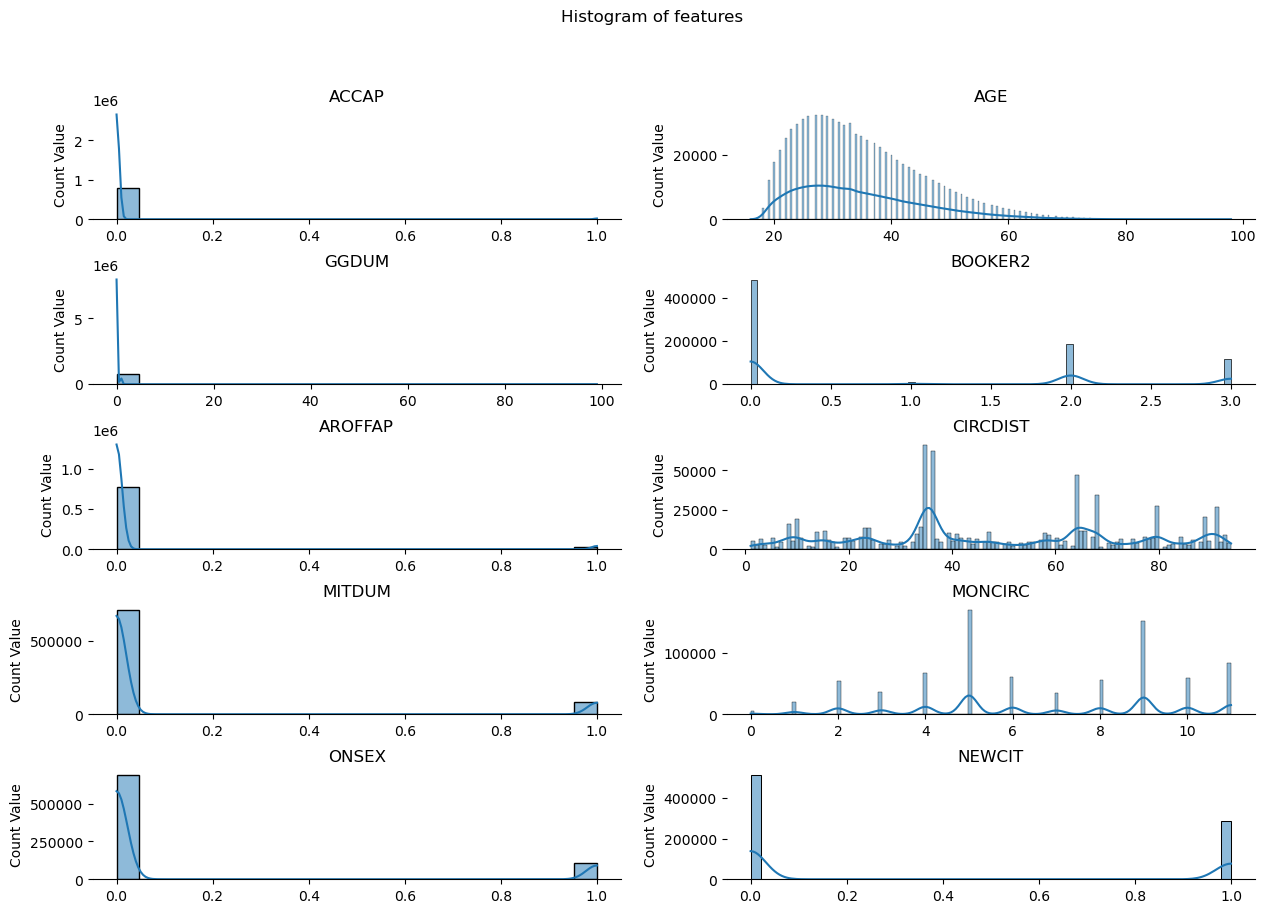

In [63]:
# Set up the figure
col_num = 2
row_num = 5
fig, axis = plt.subplots(row_num, col_num, figsize=(15, 10)) #, sharex=True)
fig.suptitle('Histogram of features ')
sns.despine(left=True)
plt.subplots_adjust(hspace = .5)

for row in range(row_num):
    for col in range(col_num):
        rowx = row*2+col
        ax=axis[row,col]
        ax.set_title(df.iloc[:,rowx].name)
        sns.histplot(df.iloc[:,rowx], kde=True, ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('Count Value');

In [64]:
high_corr(df, 0.5)

Highly correlated columns
['BOOKER2', 'A', 'CIRCDIST', 'MONCIRC', 'OFFTYPE2', 'PRIMARY', 'SAFEVALVE', 'ERIOD', 'FY', 'USSCIDN', 'OTCHPTS', 'XCRHISSR', 'LMIN', 'ENSPLT0']


USSCIDN   FY           0.993238
MONCIRC   CIRCDIST     0.990894
BOOKER2   A            0.965911
XCRHISSR  OTCHPTS      0.924038
LMIN      ENSPLT0      0.904007
ERIOD     USSCIDN      0.778029
          FY           0.740094
PRIMARY   SAFEVALVE    0.695793
          OFFTYPE2     0.639436
OFFTYPE2  SAFEVALVE    0.517610
ACCAP     ACCAP             NaN
dtype: float64

In [65]:
# These are the features that are highly correlated.
features_col = ['BOOKER2', 'A', 'CIRCDIST', 'MONCIRC', 'OFFTYPE2', 'PRIMARY', 'SAFEVALVE', 'ERIOD', 'FY', 'USSCIDN', 'OTCHPTS', 'XCRHISSR', 'LMIN', 'ENSPLT0', 'GDL']

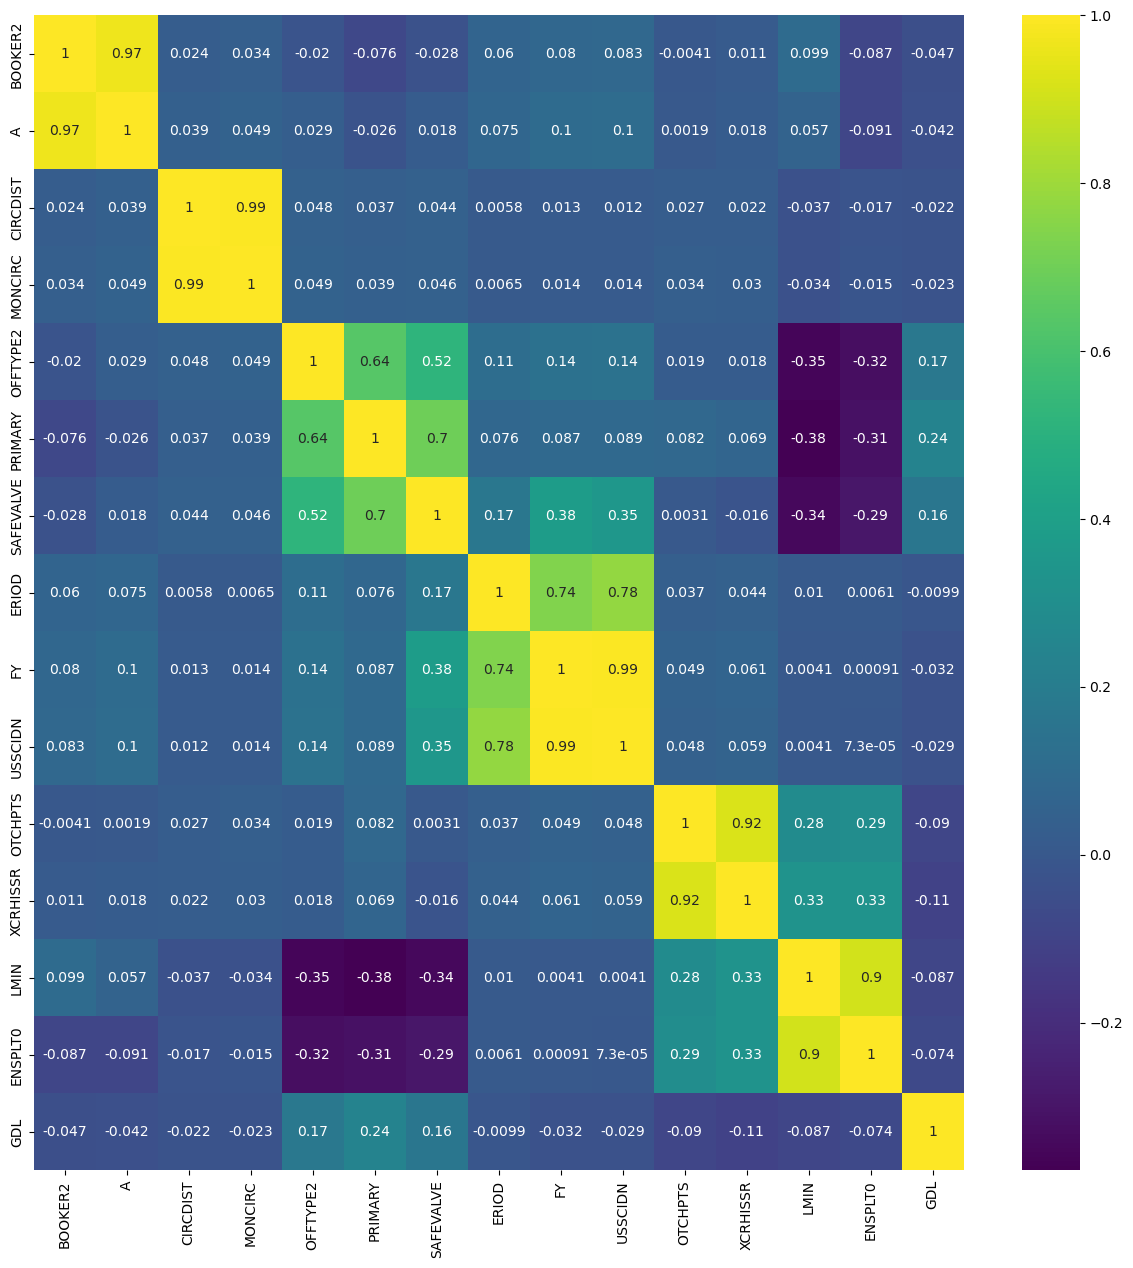

In [66]:
plt.figure(figsize = (15, 15))
sns.heatmap(df[features_col].corr(), cmap='viridis', annot=True)
plt.show();

In [67]:
# saving the completed cleaned/EDA dataset
df.to_csv('Datasets/eda_booker_report.csv')